In [ ]:

import string
import numpy as np
from PIL import Image
import os
import pickle
from pickle import load
import keras
from nltk.translate.bleu_score import corpus_bleu
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet201
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.translate.bleu_score import corpus_bleu


































[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def evaluate_xcep(image):
   #attention_plot = np.zeros((max_length, attention_features_shape))
   max_length = 33
   image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
   new_input = image_model.input
   hidden_layer = image_model.layers[-1].output
   image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
   from pickle import load
   tokenizer = load(open('/content/drive/MyDrive/captionimg/models/tokenizer_atten.p', 'rb'))
   embedding_dim = 256
   units = 512
   vocab_size = len(tokenizer.word_index) + 1
   encoder = Xception_Encoder(embedding_dim)
   decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)
   image_features_extract_model= tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/atten_model_Xcep-20240319T042159Z-001/atten_model_Xcep")

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   encoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/encoder_model_xce-20240319T042155Z-001/encoder_model_xce")
   decoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/decoder_model_xce-20240319T042155Z-001/decoder_model_xce")

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []
   res=''
   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           for i in result:
                res+=" "+i
           return res

       dec_input = tf.expand_dims([predicted_id], 0)
   #attention_plot = attention_plot[:len(result), :]

   for i in result:
       res+=" "+i

   return res

In [ ]:

class Xception_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(Xception_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x

In [ ]:
def evaluate_DEN(image):
   #attention_plot = np.zeros((max_length, attention_features_shape))
   max_length = 33
   image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
   new_input = image_model.input
   hidden_layer = image_model.layers[-1].output
   image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
   from pickle import load
   tokenizer = load(open('/content/drive/MyDrive/captionimg/models/tokenizer_atten.p', 'rb'))
   embedding_dim = 256
   units = 512
   vocab_size = len(tokenizer.word_index) + 1
   encoder = DenseNet201_Encoder(embedding_dim)
   decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)
   image_features_extract_model=tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/atten_model_Den-20240317T171351Z-001/atten_model_Den")
   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   encoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/encoder_model_Den-20240317T170035Z-001/encoder_model_Den")
   decoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/decoder_model_Den-20240317T170035Z-001/decoder_model_Den")

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []
   res=''
   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           for i in result:
                res+=" "+i
           return res

       dec_input = tf.expand_dims([predicted_id], 0)
   #attention_plot = attention_plot[:len(result), :]

   for i in result:
       res+=" "+i

   return res

In [ ]:
class DenseNet201_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(DenseNet201_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x

In [ ]:

def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None
def predict_caption_den(cap_model, image, tokenizer, max_length):
    model = DenseNet201()
    fe = Model(inputs=model.input, outputs=model.layers[-2].output)
    img_size = 224
    img = load_img(os.path.join('',image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = cap_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path
def evaluate(image):
   #attention_plot = np.zeros((max_length, attention_features_shape))
   max_length = 33
   image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
   new_input = image_model.input
   hidden_layer = image_model.layers[-1].output
   image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
   from pickle import load
   tokenizer = load(open('/content/drive/MyDrive/captionimg/models/tokenizer_atten.p', 'rb'))
   embedding_dim = 256
   units = 512
   vocab_size = len(tokenizer.word_index) + 1
   encoder = VGG16_Encoder(embedding_dim)
   decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)
   image_features_extract_model= tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/atten_model_vgg16-20240322T141948Z-001/atten_model_vgg16")

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   encoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/encoder_model_vgg16-20240322T142006Z-001/encoder_model_vgg16")
   decoder = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/decoder_model_vgg16-20240322T141938Z-001/decoder_model_vgg16")

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []
   res=''
   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           for i in result:
                res+=" "+i
           return res

       dec_input = tf.expand_dims([predicted_id], 0)
   #attention_plot = attention_plot[:len(result), :]

   for i in result:
       res+=" "+i

   return res

In [ ]:


class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x



'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Rnn_Local_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    def call(self, x, features, hidden):
        # features shape ==> (64,49,256) ==> Output from ENCODER
        # hidden shape == (batch_size, hidden_size) ==>(64,512)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (64, 49, 1)
        # Attention Function
        '''e(ij) = f(s(t-1),h(j))'''
        ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

        # self.Uattn(features) : (64,49,512)
        # self.Wattn(hidden_with_time_axis) : (64,1,512)
        # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
        # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

        # you get 1 at the last axis because you are applying score to self.Vattn
        # Then find Probability using Softmax
        '''attention_weights(alpha(ij)) = softmax(e(ij))'''

        attention_weights = tf.nn.softmax(score, axis=1)

        # attention_weights shape == (64, 49, 1)
        # Give weights to the different pixels in the image
        ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
        # context_vector shape after sum == (64, 256)
        # x shape after passing through embedding == (64, 1, 256)

        x = self.embedding(x)
        # x shape after concatenation == (64, 1,  512)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU

        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)

        x = self.fc1(output)
        # x shape == (batch_size * max_length, hidden_size)

        x = tf.reshape(x, (-1, x.shape[2]))

        # Adding Dropout and BatchNorm Layers
        x= self.dropout(x)
        x= self.batchnormalization(x)

        # output shape == (64 * 512)
        x = self.fc2(x)

        # shape : (64 * 8329(vocab))
        return x, state, attention_weights

In [ ]:
def generate_caption_for_image(model, image_path, vgg_model, tokenizer, max_length):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using VGG16
    feature = vgg_model.predict(image, verbose=0)

    # Generate caption for the image
    caption = predict_caption(model, feature, tokenizer, max_length)

    return caption

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'

    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += " " + word
        # Stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

In [ ]:
img_path='/content/drive/MyDrive/TELUGU/Flickr8k_Dataset/Flicker8k_Dataset/1288909046_d2b2b62607.jpg'

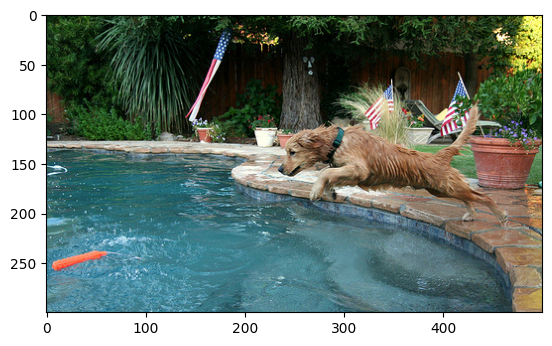

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(img_path)
plt.imshow(image)

1288909046_d2b2b62607.jpg#0	a brown dog is leaping into a garden swimming pool .


1288909046_d2b2b62607.jpg#1	A brown dog leaps into a swimming pool .

1288909046_d2b2b62607.jpg#2	A brown , fluffy dog jumping into a swimming pool after a red toy .

1288909046_d2b2b62607.jpg#3	A dog jumps into a swimming pool after a toy .

1288909046_d2b2b62607.jpg#4	A dog takes a leap of faith as he jumps into a pool to grab an orange toy .

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

references=[
    'a brown dog is leaping into a garden swimming pool',
'A brown dog leaps into a swimming pool',
'A brown fluffy dog jumping into a swimming pool after a red toy',
'A dog jumps into a swimming pool after a toy',
'A dog takes a leap of faith as he jumps into a pool to grab an orange toy'
]

# Convert each reference caption to a list of tokens
actual_captions = [[caption.split()] for caption in references]
actual_caption = [caption.split() for caption in references]

**VGG16_LSTM**

In [ ]:
max_length = 34
tokenizer = load(open("/content/drive/MyDrive/captionimg/models/tokenizer_vgg.pkl", "rb"))
model = load_model('/content/drive/MyDrive/captionimg/models/LSTM_vgg.h5')
vgg_model = VGG16()

vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
caption = generate_caption_for_image(model, img_path, vgg_model, tokenizer, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

startseq the white and white dog is flying through the air endseq
BLEU-1 score: 0.10000000000000002
Meteor score: 0.18382352941176472


**VGG16_GRU**

In [ ]:
max_length = 34

tokenizer = load(open("/content/drive/MyDrive/captionimg/models/tokenizer_vgg.pkl", "rb"))
model = load_model('/content/drive/MyDrive/captionimg/models/GRU_vgg1.h5')
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
caption = generate_caption_for_image(model, img_path, vgg_model, tokenizer, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

startseq the man is being sprayed in the air endseq
BLEU-1 score: 0.016705404228225442
Meteor score: 0.05000000000000001


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


**Xception_LSTM**

In [ ]:
max_length = 32
tokenizer = load(open("/content/drive/MyDrive/captionimg/models/tokenizer.p", "rb"))
model = load_model('/content/drive/MyDrive/captionimg/models/xce_model.h5')
xception_model = Xception()
xception_model = keras.models.Model(inputs=xception_model.inputs, outputs=xception_model.layers[-2].output)
img = load_img(img_path)
image = load_img(img_path, target_size=(299, 299))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

        # Extract features from the image using Xception
feature = xception_model.predict(image, verbose=0)

        # Generate caption using the trained model
caption = generate_desc(model, tokenizer, feature, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

start dog is jumping into the air end
BLEU-1 score: 0.186565516939506
Meteor score: 0.4049744897959184


**Xception_GRU**

In [ ]:
max_length = 32
tokenizer = load(open("/content/drive/MyDrive/captionimg/models/tokenizer.p", "rb"))
model = load_model('/content/drive/MyDrive/captionimg/models/modelGRU_9.h5')
xception_model = Xception()
xception_model = keras.models.Model(inputs=xception_model.inputs, outputs=xception_model.layers[-2].output)
img = load_img(img_path)
image = load_img(img_path, target_size=(299, 299))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

        # Extract features from the image using Xception
feature = xception_model.predict(image, verbose=0)

        # Generate caption using the trained model
caption = generate_desc(model, tokenizer, feature, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

start dog is running through the water end
BLEU-1 score: 0.093282758469753
Meteor score: 0.19132653061224492


**Attention_GRU_VGG16**

In [ ]:
caption = evaluate(img_path)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

 dark green misty rain storm gallery accompanied by trees <end>
BLEU-1 score: 0
Meteor score: 0.0


**Attention_GRU_Xception**

In [ ]:
caption = evaluate_xcep(img_path)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

 dog leaps into swimming pool after basket <end>
BLEU-1 score: 0.342036781055761
Meteor score: 0.605


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


**Attention_GRU_DenseNet**

In [ ]:
caption = evaluate_DEN(img_path)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

 brown dog jumps into pool <end>
BLEU-1 score: 0.25356583772617236
Meteor score: 0.6205128205128205


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


**DenseNet_GRU**

In [ ]:
max_length = 34
tokenizer = load(open('/content/drive/MyDrive/captionimg/models/tokenizer_den.p', 'rb'))
caption_model = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/GRU_model_.h5")
caption = predict_caption_den(caption_model, img_path, tokenizer, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

1/1 [==============================] - 0s 28ms/step
startseq two dogs are playing in the water endseq
BLEU-1 score: 0
Meteor score: 0.10101010101010102


**DenseNet_LSTM**

In [ ]:
max_length = 34
tokenizer = load(open('/content/drive/MyDrive/captionimg/models/tokenizer_den.p', 'rb'))
caption_model = tf.keras.models.load_model("/content/drive/MyDrive/captionimg/models/den_model.h5")
caption = predict_caption_den(caption_model, img_path, tokenizer, max_length)
print(caption)
# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
meteor_score_value = meteor_score(actual_caption, pred_cap)
print(f"BLEU-1 score: {bleu1_score}")
print("Meteor score:",meteor_score_value)

1/1 [==============================] - 0s 28ms/step
startseq two dogs are playing in the water endseq
BLEU-1 score: 0
Meteor score: 0.10101010101010102


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

references = [
    'A cricketer be lay on the ground between the wicket and the ball',
    'A man be lie on the ground , laugh , during a ball game',
    'A man play cricket closely inspect a shot',
    'Guy play cricket lie on the grass',
    'A cricket player just miss catch the ball'
]

# Convert each reference caption to a list of tokens
actual_captions = [[caption.split()] for caption in references]

# Generate the caption for your image
caption = "the white haired girl is catching ball through the air"  # example caption, replace with your generated caption

# Split the generated caption into a list of tokens
pred_cap = caption.split()

# Repeat the generated caption for each reference
pred_caps = [pred_cap] * len(actual_captions)

# Calculate BLEU score for all references together
bleu1_score = corpus_bleu(actual_captions, pred_caps, weights=(1.0, 0, 0, 0))
bleu2_score = corpus_bleu(actual_captions, pred_caps, weights=(0.5, 0.5, 0, 0))

print(f"BLEU-1 score: {bleu1_score}")
print(f"BLEU-2 score: {bleu2_score}")


BLEU-1 score: 0.15999999999999998
BLEU-2 score: 5.966672584960326e-155
